# <font color='palegreen'> KHL results predictor

Цель: построить модель для прогноза победителей матчей регулярного чемпионата Континентальной хоккейной лиги.

Исходными данными будут результаты матчей регулярных чемпионатов 4 сезонов: 2018/2019, 2019/2020, 2020/2021, 2021/2022. Последний сезон будет тестовым. Исходные данные будут парситься.

In [1]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## <font color='Bisque'> 1. Парсинг статистики матчей с сайта `khl.ru`

Статистика по 4 регулярным чемпионатам находится по ссылкам:
- для сезона 2018/2019 - https://www.khl.ru/calendar/671/
- для сезона 2019/2020 - https://www.khl.ru/calendar/851/
- для сезона 2020/2021 - https://www.khl.ru/calendar/1045/
- для сезона 2021/2022 - https://www.khl.ru/calendar/1097/

In [2]:
# сбор ссылок матчей

page_links = ['https://www.khl.ru/calendar/1097/00/', 'https://www.khl.ru/calendar/1045/00/', 'https://www.khl.ru/calendar/851/00/', 'https://www.khl.ru/calendar/671/00/']

section_names = []
for link in page_links:

    response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
    soup = BeautifulSoup(response.content, 'html.parser')
    sections = soup.findAll('a', attrs={'class':'card-game__hover-link_small'})

    for i in sections:
        section_names.append(i.attrs['href'])

# выбираем необходимые ссылки для сбора статистики матчей и добавляем к ним доменное имя
links = ['https://khl.ru' + element for element in section_names if 'protocol' in element]

Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\fake_useragent\utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\fake_useragent\utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


In [3]:
# сбор статистики матчей

# функция подключения к веб-странице
def connect(link):
    response = requests.get(link, headers={'User-Agent': UserAgent().chrome})
    if not response.ok:
        return response.status_code
    soup = BeautifulSoup(response.content, 'html.parser')

    return soup

#======================================================================================
# функция очистки содержимого веб-страниц от пустых строк и пробелов
def stats_cleaner(data):

    data = [x.strip('\n').strip(' ') for x in data]

    return data

#======================================================================================
all_stats, matches_missing = [], []
 

for link in tqdm_notebook(links):

    match_stats = []

    # часть статистики матча в его протоколе
    soup_protocol = connect(link)

    # находим необходимую статистику матчей из протокола
    statistics_protocol = soup_protocol.findAll('div', attrs={'class':'fineTable-totalTable d-none_768'})

    # часть матчей не игралась, но ссылки на пустые протоколы есть - выбираем не пустые протоколы
    if statistics_protocol != []:

        goals = soup_protocol.findAll('p', attrs={'class':'preview-frame__center-score roboto-condensed roboto-bold color-white title-xl'})[0].contents

        # часть статистики матча в его резюме
        soup_resume = connect(link.replace('protocol', 'resume'))

        # находим необходимую статистику матчей из резюме
        statistics_resume = soup_resume.findAll('p', attrs={'class':'roboto-condensed'})[1:21]
        # номер матча для его идентификации
        match_number_resume = soup_resume.findAll('h2', attrs={'class':'roboto-condensed roboto-bold title-md color-dark title-btns__title'})

        # находим даты проведения матчей
        soup_preview = connect(link.replace('protocol', 'preview'))
        date_preview = soup_preview.findAll('div', attrs={'class':'card-infos__item-info'})

        # добавляем в список статистики дату, время проведения и номер матча

        try:
            match_stats.append(stats_cleaner(date_preview[0].contents[1].contents)[0])
        except IndexError: 
            match_stats.append(np.NaN)

        match_stats.append(match_number_resume[0].contents[0].split('№')[1].replace(' ', ''))
        # добавляем в список статистики основную информацию
        for stat in statistics_resume:
            clean_stat = stats_cleaner(stat.contents)
            if clean_stat != [''] and clean_stat != ['n/a']:
                match_stats.append(clean_stat[0])
            else: pass

        # добавляем в список статистики дополнительную информацию
        if len(statistics_protocol[len(statistics_protocol)-2].contents) == 11 and 'Всего' in str(statistics_protocol[1].contents[9].contents[7].contents[1]):
        
            for stat in statistics_protocol[1].contents[9].contents:
                if stat != '\n':
                    clean_stat = stats_cleaner(stat.contents[1].contents) 
                    match_stats.append(clean_stat[0])
                else: pass

    #=============================================================================================================================================================
        elif len(statistics_protocol[len(statistics_protocol)-2].contents) == 11 and 'овертайм' in str(statistics_protocol[1].contents[9].contents[7].contents[1]):
        
            for stat in statistics_protocol[2].contents[9].contents:
                if stat != '\n':
                    clean_stat = stats_cleaner(stat.contents[1].contents) 
                    match_stats.append(clean_stat[0])
                else: pass

    #=============================================================================================================================================================
        elif len(statistics_protocol) == 3 and len(statistics_protocol[len(statistics_protocol)-2].contents) == 13:

            for stat in statistics_protocol[1].contents[11].contents:
                if stat != '\n':
                    clean_stat = stats_cleaner(stat.contents[1].contents) 
                    match_stats.append(clean_stat[0])
                else: pass

        else:
            for stat in statistics_protocol[2].contents[11].contents:
                if stat != '\n':
                    clean_stat = stats_cleaner(stat.contents[1].contents) 
                    match_stats.append(clean_stat[0])
                else: pass
        
        # для идентификации овертаймов
        if len(statistics_protocol[len(statistics_protocol)-2].contents) == 11 and ('овертайм' not in statistics_protocol[0].contents[9].contents[7].contents[1].contents[0].replace(' ', '').replace('\n', '')):
            match_stats.append('main_time')
        else: match_stats.append('add_time')


        # добавляем информацию о кол-ве заброшенных шайб с учетом буллитов
        if goals[0] != '\n':
            try:
                goal_h = goals[0].replace(' ', '').replace('\n', '')
            except TypeError:
                goal_h = goals[0].contents[0]

            try:
                goal_a = goals[3].replace(' ', '').replace('\n', '')
            except IndexError:
                pass
            except TypeError:
                goal_a = goals[3].contents[0]

        else:
            goal_h = goals[1].contents[0]
            goal_a = goals[4].replace(' ', '').replace('\n', '').replace('Б', '').replace('OT', '')

        match_stats.append(goal_h)
        match_stats.append(goal_a)

        # match_stats.remove('Всего')

        # проверка наличия данных о пройденной дистанции и времени владения шайбой (есть не во всех матчах, удаляется) 
        if len(match_stats) == 32:
            del match_stats[15:19]
        else: pass

        all_stats.append(match_stats)

    else: matches_missing.append(link)

time.sleep(0.5)

  0%|          | 0/2789 [00:00<?, ?it/s]

Создаем датасет для обучения и тестирования моделей

In [63]:
# признаки:

# date          - дата и время проведения матча
# match         - номер матча
# team          - команда
# score         - общее кол-во забитых командой шайб
# ppp           - кол-во шайб, забитых в большинстве
# ppk           - кол-во шайб, забитых в меньшинстве
# numa          - численные преимущества
# wt            - выигранные вбрасывания
# pt            - штрафное время (минуты)
# sog           - броски по воротам
# bs            - блокированные броски
# pm            - силовые приемы
# at            - время в атаке (минуты)
# tot           - проверка корректности работы парсинга
# end           - вариант окончания матча (в основное или дополнительное время)
# final_score   - итоговый счет (с учетом буллитов)
# _h            - домашняя команда
# _a            - гостевая команда

pd.set_option('display.max_columns', 50)

data = pd.DataFrame(all_stats, columns=['date', 'match', 'team_h', 'score_h', 'ppp_h', 'ppp_a', 'ppk_h', 'ppk_a', 'numa_h', 'numa_a', 'wt_h', 'wt_a', 'pt_h', 'pt_a', 'sog_h', 'sog_a', 'team_a', 'score_a', 'bs_h', 'pm_h', 'at_h', 'tot',
                                        'bs_a', 'pm_a', 'at_a', 'end', 'final_score_h', 'final_score_a'])

# удаляем ненужный признак 'del'  __________сделать проверку по количеству значений Всего и длине датасета
#data.drop(columns='del', inplace=True)


# сортируем признаки по принадлежности к командам
data_sorted = data.iloc[:, [0,1,2,16,3,17,4,6,8,10,12,14,18,19,20,5,7,9,11,13,15,22,23,24,25,26,27,21]]
data_sorted.head()

,date,match,team_h,team_a,score_h,score_a,ppp_h,ppk_h,numa_h,wt_h,pt_h,sog_h,bs_h,pm_h,at_h,ppp_a,ppk_a,numa_a,wt_a,pt_a,sog_a,bs_a,pm_a,at_a,end,final_score_h,final_score_a,tot
0,14.01.2022 12:30,589,Адмирал,Сибирь,3,2,1,0,4,29,10,16,29,7,10:35,1,0,5,29,8,32,10,16,15:06,main_time,3,2,Всего
1,13.01.2022 17:00,582,Автомобилист,Северсталь,5,2,2,0,5,37,8,40,12,15,16:34,0,0,4,20,10,33,16,5,14:13,main_time,5,2,Всего
2,13.01.2022 19:30,588,СКА,ХК Сочи,2,1,0,0,4,31,4,33,10,6,21:07,0,0,2,19,8,21,22,10,09:13,main_time,2,1,Всего
3,12.01.2022 12:30,578,Адмирал,Сибирь,2,1,0,0,2,24,4,30,27,10,12:54,0,1,1,35,6,27,22,17,13:11,main_time,2,1,Всего
4,12.01.2022 19:00,580,Нефтехимик,Трактор,4,2,0,0,2,27,2,26,23,13,10:02,0,0,1,31,4,24,9,13,16:40,main_time,4,2,Всего


## <font color='Bisque'> 2. Preprocessing & Exploratory data analysis

In [64]:
data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           2779 non-null   object
 1   match          2783 non-null   object
 2   team_h         2783 non-null   object
 3   team_a         2783 non-null   object
 4   score_h        2783 non-null   object
 5   score_a        2783 non-null   object
 6   ppp_h          2783 non-null   object
 7   ppk_h          2783 non-null   object
 8   numa_h         2783 non-null   object
 9   wt_h           2783 non-null   object
 10  pt_h           2783 non-null   object
 11  sog_h          2783 non-null   object
 12  bs_h           2783 non-null   object
 13  pm_h           2783 non-null   object
 14  at_h           2783 non-null   object
 15  ppp_a          2783 non-null   object
 16  ppk_a          2783 non-null   object
 17  numa_a         2783 non-null   object
 18  wt_a           2783 non-null

4 пропуска в признаке `date`. Посмотрим на строки с ними

In [65]:
data_sorted[data_sorted.date.isna()]

,date,match,team_h,team_a,score_h,score_a,ppp_h,ppk_h,numa_h,wt_h,pt_h,sog_h,bs_h,pm_h,at_h,ppp_a,ppk_a,numa_a,wt_a,pt_a,sog_a,bs_a,pm_a,at_a,end,final_score_h,final_score_a,tot
1416,NaN,1,Див. Боброва,Див. Чернышёва,7,4,0,0,0,10,0,32,,,06:36,0,0,0,4,0,7,,,04:27,main_time,7,4,Всего
1417,NaN,2,Див. Тарасова,Див. Харламова,8,6,0,0,0,9,0,22,,,05:21,0,0,0,10,0,7,,,04:30,main_time,8,6,Всего
1418,NaN,3,Див. Харламова,Див. Чернышёва,8,9,0,0,0,6,0,25,8,25,32.00,0,0,0,13,0,7,9,28,32.14,main_time,8,9,Всего
1419,NaN,4,Див. Боброва,Див. Тарасова,7,6,0,0,0,9,0,28,7,28,25.00,0,0,0,12,0,7,6,21,28.57,main_time,7,6,Всего


Данные строки нужно удалить, т.к. они содержат ненужную информацию о Матче всех звезд

In [66]:
data_sorted.drop(index = data_sorted[data_sorted.date.isna()].index, inplace=True)

Проверим уникальные значения в признаках `team_h` и `team_a` для определения дополнительных строк с ненужной информацией о Матчах всех звезд

In [67]:
print(data_sorted['team_h'].unique(), '\n\n', data_sorted['team_a'].unique())

['Адмирал' 'Автомобилист' 'СКА' 'Нефтехимик' 'Витязь' 'Динамо М' 'Амур'
 'Куньлунь РС' 'Металлург Мг' 'Северсталь' 'Авангард' 'ХК Сочи' 'ЦСКА'
 'Сибирь' 'Барыс' 'Салават Юлаев' 'Трактор' 'Йокерит' 'Локомотив'
 'Торпедо' 'Динамо Мн' 'Динамо Р' 'Ак Барс' 'Спартак' 'Слован'
 'Дивизион Чернышёва' 'Дивизион Тарасова' 'Дивизион Харламова'] 

 ['Сибирь' 'Северсталь' 'ХК Сочи' 'Трактор' 'Йокерит' 'Ак Барс' 'Спартак'
 'Барыс' 'Авангард' 'Нефтехимик' 'Локомотив' 'Динамо Мн' 'Торпедо'
 'Витязь' 'Металлург Мг' 'Динамо Р' 'Динамо М' 'СКА' 'Амур'
 'Салават Юлаев' 'Куньлунь РС' 'Автомобилист' 'ЦСКА' 'Адмирал' 'Слован'
 'Дивизион Харламова' 'Дивизион Боброва' 'Дивизион Тарасова']


Удаляем ненужные строки

In [68]:
data_sorted.drop(index = data_sorted[data_sorted.team_h.isin(['Дивизион Чернышёва', 'Дивизион Харламова', 'Дивизион Тарасова'])].index, inplace=True)

Проверяем качество парсинга (в признаке `tot` должно быть одно значение "Всего")

In [69]:
data_sorted.tot.unique()

array(['Всего'], dtype=object)

Удаляем ненужный столбец `tot`

In [70]:
data_sorted.drop(columns='tot', inplace=True)

Встречаются пропуски (значения ' ') в признаках `bs_a` и `pm_a`, заполняем их значениями из признаков `bs_h` и `pm_h` соответственно

In [71]:
data_sorted.loc[data_sorted[data_sorted.bs_a == ''].index, 'bs_a'] = data_sorted.loc[data_sorted[data_sorted.bs_a == ''].index, 'bs_h']
data_sorted.loc[data_sorted[data_sorted.pm_a == ''].index, 'pm_a'] = data_sorted.loc[data_sorted[data_sorted.pm_a == ''].index, 'pm_h']

Приводим типы данных к нужному формату

In [72]:
data_sorted['date'] = pd.to_datetime(data_sorted['date'], format='%d.%m.%Y %H:%M')

features_to_int = [data_sorted.columns[1]] + data_sorted.columns[4:14].to_list() + data_sorted.columns[15:23].to_list() + data_sorted.columns[25:27].to_list()

# заменяем пропущенные 
for column in features_to_int:
    try:
        data_sorted[column] = data_sorted[column].astype('int64')

    except ValueError:
        pass

data_sorted[['at_h', 'at_a']] = pd.to_datetime(data_sorted[['at_h', 'at_a']].stack(), format='%M:%S').dt.time.unstack()

# переводим время в атаке в секунды
def sec_conv (data):
    return data.minute*60 + data.second

data_sorted['at_h'], data_sorted['at_a'] = data_sorted['at_h'].apply(sec_conv), data_sorted['at_a'].apply(sec_conv)
# ==================================

data_sorted[['team_h', 'team_a', 'end']] = data_sorted[['team_h', 'team_a', 'end']].astype('str')

data_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2775 entries, 0 to 2782
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2775 non-null   datetime64[ns]
 1   match          2775 non-null   int64         
 2   team_h         2775 non-null   object        
 3   team_a         2775 non-null   object        
 4   score_h        2775 non-null   int64         
 5   score_a        2775 non-null   int64         
 6   ppp_h          2775 non-null   int64         
 7   ppk_h          2775 non-null   int64         
 8   numa_h         2775 non-null   int64         
 9   wt_h           2775 non-null   int64         
 10  pt_h           2775 non-null   int64         
 11  sog_h          2775 non-null   int64         
 12  bs_h           2775 non-null   int64         
 13  pm_h           2775 non-null   int64         
 14  at_h           2775 non-null   int64         
 15  ppp_a          2775 n

Добавляем целевой признак

In [73]:
# добавляем признак, определяющий победу домашней команды

data_sorted['home_win'] = np.where(data_sorted.final_score_h > data_sorted.final_score_a, 1, 0)

### <font color='mediumpurple'> 2.1 Feature generation

Добавляем порядковый номер сезона

In [74]:
data_sorted['season'] = np.where(data_sorted['date'] < pd.Timestamp('2019-06-01 00:00:00'), 1, np.NaN)
data_sorted['season'] = np.where((data_sorted['date'] > pd.Timestamp('2019-08-01 00:00:00')) & (data_sorted['date'] < pd.Timestamp('2020-06-01 00:00:00')), 2, data_sorted['season'])
data_sorted['season'] = np.where((data_sorted['date'] > pd.Timestamp('2020-08-01 00:00:00')) & (data_sorted['date'] < pd.Timestamp('2021-06-01 00:00:00')), 3, data_sorted['season'])
data_sorted['season'] = np.where((data_sorted['date'] > pd.Timestamp('2021-08-01 00:00:00')), 4, data_sorted['season'])
data_sorted['season'] = data_sorted['season'].astype('int64')

Сортируем датасет по дате проведения матчей

In [75]:
data_sorted.sort_values(by='date', inplace=True)
data_sorted.reset_index(inplace=True, drop=True)

Добавляем кол-во очков у каждой команды

In [76]:
#2 - победа
#1 - поражение в ОТ или по буллитам
#0 - поражение в основное время

# добавляем очки домашней команды по результатам матча
data_sorted['points_h'] = np.where(data_sorted.home_win == 1, 2, np.NaN)
data_sorted['points_h'] = np.where((data_sorted.home_win == 0) & (data_sorted.end == 'add_time'), 1, data_sorted['points_h'])
data_sorted['points_h'] = np.where((data_sorted.home_win == 0) & (data_sorted.end == 'main_time'), 0, data_sorted['points_h'])

# добавляем очки гостевой команды по результатам матча
data_sorted['points_a'] = np.where(data_sorted.home_win == 0, 2, np.NaN)
data_sorted['points_a'] = np.where((data_sorted.home_win == 1) &  (data_sorted.end == 'add_time'), 1, data_sorted['points_a'])
data_sorted['points_a'] = np.where((data_sorted.home_win == 1) &  (data_sorted.end == 'main_time'), 0, data_sorted['points_a'])

In [77]:
# tp_h - кол-во очков домашней команды
# tp_a - кол-во очков гостевой команды

data_sorted[['tp_h', 'tp_a']] = np.NaN

# создаем колонки для подсчета очков индивидульно по каждой команде
for team in data_sorted.team_h.unique():
    data_sorted['p_{}'.format(team)] = np.NaN

# создаем пустой датафрейм для добавления очков по каждому сезону
d = {}
for i in range(len(data_sorted.dtypes)):
    d[data_sorted.dtypes.index[i]] = pd.Series(dtype=data_sorted.dtypes.values[i])

data_sorted_v1 = pd.DataFrame(d)

for season in data_sorted['season'].unique():

    df = data_sorted[data_sorted['season'] == season]

    for team in data_sorted.team_h.unique():
        
        df['p_{}'.format(team)] = np.where(df.team_h == team, pd.Series(np.where(df.team_h == team, df.points_h, np.where(df.team_a == team, df.points_a, 0)).cumsum()).shift().fillna(0), df['p_{}'.format(team)])
        df['p_{}'.format(team)] = np.where(df.team_a == team, pd.Series(np.where(df.team_a == team, df.points_a, np.where(df.team_h == team, df.points_h, 0)).cumsum()).shift().fillna(0), df['p_{}'.format(team)])
    
        df['tp_h'] = np.where(df.team_h == team, df['p_{}'.format(team)], df['tp_h'])
        df['tp_a'] = np.where(df.team_a == team, df['p_{}'.format(team)], df['tp_a'])

    data_sorted_v1 = pd.concat([data_sorted_v1, df])

data_sorted_v1.drop(columns=data_sorted_v1.columns[-29:-27].to_list() + data_sorted_v1.columns[-25:].to_list(), inplace=True)

Добавляем разницу очков играющих команд относительно домашней

In [78]:
data_sorted_v1['delta_p'] = data_sorted_v1['tp_h'] - data_sorted_v1['tp_a']

Добавляем число, месяц, день недели проведения матча и является ли день выходным

In [79]:
data_sorted_v1['day'] = data_sorted_v1.date.dt.day
data_sorted_v1['month'] = data_sorted_v1.date.dt.month
data_sorted_v1['day_of_week'] = data_sorted_v1.date.dt.day_of_week
data_sorted_v1['weekend'] = np.where((data_sorted_v1['day_of_week'] == 5) | (data_sorted_v1['day_of_week'] == 6), 1, 0)

Определяем макс. кол-во дней отдыха между играми

In [80]:
# определяем макс. кол-во дней отдыха среди команд в рамках одного сезона (исключаем команду Слован, т.к. она играла только в 1м сезоне, и команду Адмирал - не играла в 3м сезоне)
max_rest = []

for season in data_sorted_v1['season'].unique():
    for team in data_sorted_v1.team_h.unique()[np.where((data_sorted_v1.team_h.unique() != 'Слован') & (data_sorted_v1.team_h.unique() != 'Адмирал'))]:
        df = data_sorted_v1[((data_sorted_v1.team_h == team) | (data_sorted_v1.team_a == team)) & (data_sorted_v1.season == season)]
      
        max_rest.append(round((df.date[1:] - df.date.shift()[1:]).max().days + (df.date[1:] - df.date.shift()[1:]).max().seconds/86400))

max(max_rest)

20

Определяем наличие переезда у команд перед матчем, кол-во дней отдыха между играми, наличие предыдущего напряженного матча (завершившегося в ОТ или по буллитам)

In [81]:
# определяем города, в которых базируются клубы
# city_h    - город домашней команды
# reloc_h   - переезд домашней команды перед матчем
# reloc_a   - переезд гостевой команды перед матчем
# rest_h    - кол-во дней отдыха домашней команды перед матчем
# rest_a    - кол-во дней отдыха гостевой команды перед матчем
# intense_h - наличие предыдущего напряженного матча у домашней команды
# intense_a - наличие предыдущего напряженного матча у гостевой команды


teams = data_sorted_v1.team_h.unique().tolist()
cities = ['Казань', 
            'Челябинск',
            'Магнитогорск',
            'Екатеринбург',
            'Москва',
            'Москва',
            'Череповец',
            'Ярославль',
            'Хельсинки',
            'Нижний Новгород',
            'Нижнекамск',
            'Сочи',
            'Санкт-Петербург',
            'Рига',
            'Братислава',
            'Омск',
            'Минск',
            'Подольск',
            'Новосибирск',
            'Москва',
            'Хабаровск',
            'Нур-Султан',
            'Уфа',
            'Пекин',
            'Владивосток']

d_cities = dict(zip(teams, cities))

data_sorted_v1['city_h'] = data_sorted_v1['team_h'].map(d_cities)
data_sorted_v1[['reloc_h', 'reloc_a', 'rest_h', 'rest_a', 'intense_h', 'intense_a']] = np.NaN


for team in data_sorted_v1.team_h.unique():

    index = data_sorted_v1[(data_sorted_v1['team_h'] == team) | (data_sorted_v1['team_a'] == team)].index



# определяем наличие переезда у домашней команды____________________________________________________________
    data_sorted_v1.loc[index, 'reloc_h'] = np.where(
        data_sorted_v1.loc[index, 'team_h'] == team, 
        np.where((data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift()).isna() | (data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift() == 1), 
        0, 
        np.where(data_sorted_v1.loc[index, 'city_h'] == data_sorted_v1.loc[index, 'city_h'].shift(), 
        0, 
        1)), 
        data_sorted_v1.loc[index, 'reloc_h'])

# определяем наличие переезда у гостевой команды
    data_sorted_v1.loc[index, 'reloc_a'] = np.where(
        data_sorted_v1.loc[index, 'team_a'] == team,
        np.where((data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift()).isna() | (data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift() == 1), 
        1, 
        np.where(data_sorted_v1.loc[index, 'city_h'] == data_sorted_v1.loc[index, 'city_h'].shift(), 
        0, 
        1)), 
        data_sorted_v1.loc[index, 'reloc_a'])



# определяем кол-во дней отдыха у домашней команды_____________________________________________________________
    data_sorted_v1.loc[index, 'rest_h'] = np.where(
        data_sorted_v1.loc[index, 'team_h'] == team, 
        np.where((data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift()).isna() | (data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift() == 1), 
        max(max_rest), # для первых матчей проставляем макс. кол-во дней отдыха в течение сезона 
        (data_sorted_v1.loc[index, 'date'] - data_sorted_v1.loc[index, 'date'].shift()).dt.total_seconds()/86400), 
        data_sorted_v1.loc[index, 'rest_h'])

# определяем кол-во дней отдыха у гостевой команды
    data_sorted_v1.loc[index, 'rest_a'] = np.where(
        data_sorted_v1.loc[index, 'team_a'] == team,
        np.where((data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift()).isna() | (data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift() == 1), 
        max(max_rest), # для первых матчей проставляем макс. кол-во дней отдыха в течение сезона
        (data_sorted_v1.loc[index, 'date'] - data_sorted_v1.loc[index, 'date'].shift()).dt.total_seconds()/86400), 
        data_sorted_v1.loc[index, 'rest_a'])



# определяем наличие напряженного матча у домашней команды________________________________________________________
    data_sorted_v1.loc[index, 'intense_h'] = np.where(
        data_sorted_v1.loc[index, 'team_h'] == team, 
        np.where((data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift()).isna() | (data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift() == 1), 
        0,
        np.where(data_sorted_v1.loc[index, 'end'].shift() == 'add_time', 
        1, 
        0)), 
        data_sorted_v1.loc[index, 'intense_h'])

# определяем наличие напряженного матча у гостевой команды
    data_sorted_v1.loc[index, 'intense_a'] = np.where(
        data_sorted_v1.loc[index, 'team_a'] == team, 
        np.where((data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift()).isna() | (data_sorted_v1.loc[index, 'season'] - data_sorted_v1.loc[index, 'season'].shift() == 1), 
        0,
        np.where(data_sorted_v1.loc[index, 'end'].shift() == 'add_time', 
        1, 
        0)), 
        data_sorted_v1.loc[index, 'intense_a'])

data_sorted_v1.drop(columns=['city_h'], inplace=True)

Добавляем кол-во побед дома у домашней команды и кол-во побед в гостях у гостевой команды на момент проведения матча

In [82]:
# win_h   - кол-во побед дома у домашней команды
# win_a   - кол-во побед в гостях у гостевой команды

data_sorted_v1[['win_h', 'win_a']] = np.NaN

for season in data_sorted_v1.season.unique():
    for team in data_sorted_v1.team_h.unique():

        index_h = data_sorted_v1[(data_sorted_v1['team_h'] == team) & (data_sorted_v1['season'] == season)].index
        index_a = data_sorted_v1[(data_sorted_v1['team_a'] == team) & (data_sorted_v1['season'] == season)].index

# кол-во побед дома у домашней команды
        data_sorted_v1.loc[index_h, 'win_h'] = np.where(
            (data_sorted_v1.loc[index_h, 'season'] - data_sorted_v1.loc[index_h, 'season'].shift()).isna() | (data_sorted_v1.loc[index_h, 'season'] - data_sorted_v1.loc[index_h, 'season'].shift() == 1), 
            0,
            data_sorted_v1.loc[index_h, 'home_win'].shift().cumsum()
            )


# кол-во побед в гостях у гостевой команды
        data_sorted_v1.loc[index_a, 'win_a'] = np.where(
            (data_sorted_v1.loc[index_a, 'season'] - data_sorted_v1.loc[index_a, 'season'].shift()).isna() | (data_sorted_v1.loc[index_a, 'season'] - data_sorted_v1.loc[index_a, 'season'].shift() == 1), 
            0,
            (1 - data_sorted_v1.loc[index_a, 'home_win'].shift()).cumsum()
            )

Добавляем историю игр между командами (кол-во побед в очных противостояниях с первого рассматриваемого в данной работе сезона `2018/2019`)

In [83]:
# ftf_h   - кол-во побед домашней команды в очных противостояниях
# ftf_a   - кол-во побед гостевой команды в очных противостояниях

data_sorted_v1[['ftf_h', 'ftf_a']] = np.NaN

for team_h in data_sorted_v1.team_h.unique():
    for team_a in data_sorted_v1.team_a.unique():

        index = data_sorted_v1[((data_sorted_v1.team_h == team_h) & (data_sorted_v1.team_a == team_a)) | ((data_sorted_v1.team_h == team_a) & (data_sorted_v1.team_a == team_h))].index

# кол-во очных побед дома у домашней команды
        data_sorted_v1.loc[index, 'ftf_h'] = np.where(
        data_sorted_v1.loc[index, 'team_h'] == team_h, 

        pd.Series(np.where(data_sorted_v1.loc[index, 'team_h'] == team_h, data_sorted_v1.loc[index, 'home_win'], (1-data_sorted_v1.loc[index, 'home_win'])).cumsum()).shift().fillna(0),

        pd.Series(np.where(data_sorted_v1.loc[index, 'team_h'] == team_a, data_sorted_v1.loc[index, 'home_win'], (1-data_sorted_v1.loc[index, 'home_win'])).cumsum()).shift().fillna(0)
        )

# кол-во очных побед дома у гостевой команды
        data_sorted_v1.loc[index, 'ftf_a'] = np.where(
        data_sorted_v1.loc[index, 'team_a'] == team_a, 

        pd.Series(np.where(data_sorted_v1.loc[index, 'team_a'] == team_a, (1-data_sorted_v1.loc[index, 'home_win']), data_sorted_v1.loc[index, 'home_win']).cumsum()).shift().fillna(0),

        pd.Series(np.where(data_sorted_v1.loc[index, 'team_a'] == team_h, (1-data_sorted_v1.loc[index, 'home_win']), data_sorted_v1.loc[index, 'home_win']).cumsum()).shift().fillna(0)
        )

Добавляем среднее кол-во очков оппонентов, против которых играли команды до матча.

In [84]:
# Данный признак будет отвечать за силу оппонентов, против которых играли команды

# mop_h   - среднее кол-во очков оппонентов домашней команды
# mop_a   - среднее кол-во очков оппонентов гостевой команды

data_sorted_v1[['mop_h', 'mop_a']] = np.NaN

for season in data_sorted_v1.season.unique():
    for team in data_sorted_v1.team_h.unique():

        index_h = data_sorted_v1[(data_sorted_v1['team_h'] == team) & (data_sorted_v1['season'] == season)].index
        index_a = data_sorted_v1[(data_sorted_v1['team_a'] == team) & (data_sorted_v1['season'] == season)].index

# создаем массив из очков гостевых команд при игре дома и очков домашних команд при игре в гостях
        tp = pd.concat([data_sorted_v1.loc[index_a, 'tp_h'], data_sorted_v1.loc[index_h, 'tp_a']]).sort_index()

# создаем датафрейм из кол-ва проведенных игр
        games_count = pd.DataFrame(index=tp.index, columns=['number_of_games'], data=np.ones(len(tp.index)))


# среднее кол-во очков оппонентов домашней команды
        data_sorted_v1.loc[index_h, 'mop_h'] = np.where(
            ((data_sorted_v1.loc[tp.index, 'season'] - data_sorted_v1.loc[tp.index, 'season'].shift()).isna() | (data_sorted_v1.loc[tp.index, 'season'] - data_sorted_v1.loc[tp.index, 'season'].shift() == 1)).loc[index_h], 
            0,
            tp.shift().cumsum()[index_h] / games_count.shift().cumsum().loc[index_h, 'number_of_games'].values
            )


# среднее кол-во очков оппонентов гостевой команды
        data_sorted_v1.loc[index_a, 'mop_a'] = np.where(
            ((data_sorted_v1.loc[tp.index, 'season'] - data_sorted_v1.loc[tp.index, 'season'].shift()).isna() | (data_sorted_v1.loc[tp.index, 'season'] - data_sorted_v1.loc[tp.index, 'season'].shift() == 1)).loc[index_a], 
            0,
            tp.shift().cumsum()[index_a] / games_count.shift().cumsum().loc[index_a, 'number_of_games'].values
            )

Приводим типы добавленных признаков к нужному формату

In [85]:
data_sorted_v1[data_sorted_v1.columns[29:46]] = data_sorted_v1[data_sorted_v1.columns[29:46]].astype('int64')

### <font color='mediumpurple'> 2.2 EDA

Проверяем на соответствие кол-во матчей, по которым спарсена информация, фактической нумерации матчей

In [86]:
def empty_matches_count (season, matches_missing):
    if season == 1:
        text = '/671/'
    elif season == 2:
        text = '/851/'
    elif season == 3:
        text = '/1045/'
    else:
        text = '/1097/'

    return len([x for x in matches_missing if text in x])

for season in range(1, 5):
    if data_sorted_v1[data_sorted_v1.season == season].match.max() != data_sorted_v1[data_sorted_v1.season == season].match.shape[0] + empty_matches_count(season, matches_missing):
        print('По {} сезону есть несоответствие между кол-вом матчей, по которым спарсена информация, и фактической нумерацией матчей'.format(season))
    else:
        pass

По 4 сезону есть несоответствие между кол-вом матчей, по которым спарсена информация, и фактической нумерацией матчей


По 4 сезону (2021/2022) есть пропуски в фактической нумерации матчей. Информация спарсена по всем фактически проведенным играм.

Удаляем более не нужные признаки с датой, нумерацией матчей, кол-вом забитых шайб в основное время и ОТ, вариантом окончания матчей.

In [87]:
data_sorted_v1.drop(columns=['date', 'match', 'score_h', 'score_a', 'end'], inplace=True)


Проводим EDA.

In [88]:
data_sorted_v1.describe()

,ppp_h,ppk_h,numa_h,wt_h,pt_h,sog_h,bs_h,pm_h,at_h,ppp_a,ppk_a,numa_a,wt_a,pt_a,sog_a,bs_a,pm_a,at_a,final_score_h,final_score_a,home_win,season,tp_h,tp_a,delta_p,day,month,day_of_week,weekend,reloc_h,reloc_a,rest_h,rest_a,intense_h,intense_a,win_h,win_a,ftf_h,ftf_a,mop_h,mop_a
count,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.00000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000
mean,0.700901,0.073153,3.579099,28.785586,9.438919,30.029189,12.716036,13.811532,755.389189,0.599640,0.060541,3.280721,27.729009,10.09045,21.915315,12.844324,13.131532,698.024505,2.664144,2.449369,0.539459,2.379459,31.866667,32.123243,-0.256577,15.808649,8.032793,2.924685,0.274595,0.338378,0.971532,2.973333,2.867027,0.233153,0.223784,7.563604,6.539099,2.358919,2.389189,15.474321,15.516894
std,0.836218,0.277847,1.705455,6.281644,7.699788,7.362110,5.050867,6.452657,189.316604,0.767537,0.244499,1.620248,6.079746,7.62037,7.407471,4.771972,6.634309,183.499274,1.625431,1.571033,0.498530,1.098506,21.436402,21.523615,13.894770,8.822805,4.111461,1.998671,0.446390,0.473243,0.166337,2.882337,10.854280,0.422915,0.416854,5.296287,4.967069,2.242710,2.267579,9.643833,9.605371
min,0.000000,0.000000,0.000000,11.000000,0.000000,11.000000,1.000000,1.000000,258.000000,0.000000,0.000000,0.000000,7.000000,0.00000,8.000000,1.000000,1.000000,231.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-63.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,24.000000,6.000000,25.000000,9.000000,9.000000,622.000000,0.000000,0.000000,2.000000,23.000000,6.00000,17.000000,9.000000,8.000000,568.500000,1.000000,1.000000,0.000000,1.000000,14.000000,14.000000,-7.000000,8.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.000000,7.320513,7.174242
50%,1.000000,0.000000,3.000000,29.000000,8.000000,30.000000,12.000000,13.000000,740.000000,0.000000,0.000000,3.000000,27.000000,8.00000,19.000000,12.000000,12.000000,680.000000,3.000000,2.000000,1.000000,2.000000,29.000000,30.000000,0.000000,16.000000,10.000000,3.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,7.000000,6.000000,2.000000,2.000000,15.230769,15.407407
75%,1.000000,0.000000,5.000000,33.000000,11.000000,35.000000,16.000000,17.000000,878.000000,1.000000,0.000000,4.000000,32.000000,12.00000,25.000000,16.000000,17.000000,811.000000,4.000000,3.000000,1.000000,3.000000,47.000000,48.000000,7.000000,23.500000,11.000000,5.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,11.000000,10.000000,4.000000,4.000000,23.329457,23.458042
max,5.000000,4.000000,11.000000,57.000000,91.000000,61.000000,36.000000,49.000000,1740.000000,4.000000,2.000000,10.000000,52.000000,66.00000,64.000000,34.000000,55.000000,1446.000000,9.000000,9.000000,1.000000,4.000000,104.000000,101.000000,65.000000,31.000000,12.000000,6.000000,1.000000,1.000000,1.000000,20.000000,554.000000,1.000000,1.000000,26.000000,25.000000,12.000000,13.000000,37.603448,35.606557


Требуется нормализация данных.

In [89]:
print('Кол-во пропусков в данных: {}'.format(data_sorted_v1.isna().sum().sum()), 'Кол-во дубликатов: {}'.format(data_sorted_v1.duplicated().sum()), sep='\n\n')

Кол-во пропусков в данных: 0

Кол-во дубликатов: 0


In [90]:
data_sorted_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2775 entries, 0 to 2774
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   team_h         2775 non-null   object 
 1   team_a         2775 non-null   object 
 2   ppp_h          2775 non-null   int64  
 3   ppk_h          2775 non-null   int64  
 4   numa_h         2775 non-null   int64  
 5   wt_h           2775 non-null   int64  
 6   pt_h           2775 non-null   int64  
 7   sog_h          2775 non-null   int64  
 8   bs_h           2775 non-null   int64  
 9   pm_h           2775 non-null   int64  
 10  at_h           2775 non-null   int64  
 11  ppp_a          2775 non-null   int64  
 12  ppk_a          2775 non-null   int64  
 13  numa_a         2775 non-null   int64  
 14  wt_a           2775 non-null   int64  
 15  pt_a           2775 non-null   int64  
 16  sog_a          2775 non-null   int64  
 17  bs_a           2775 non-null   int64  
 18  pm_a    

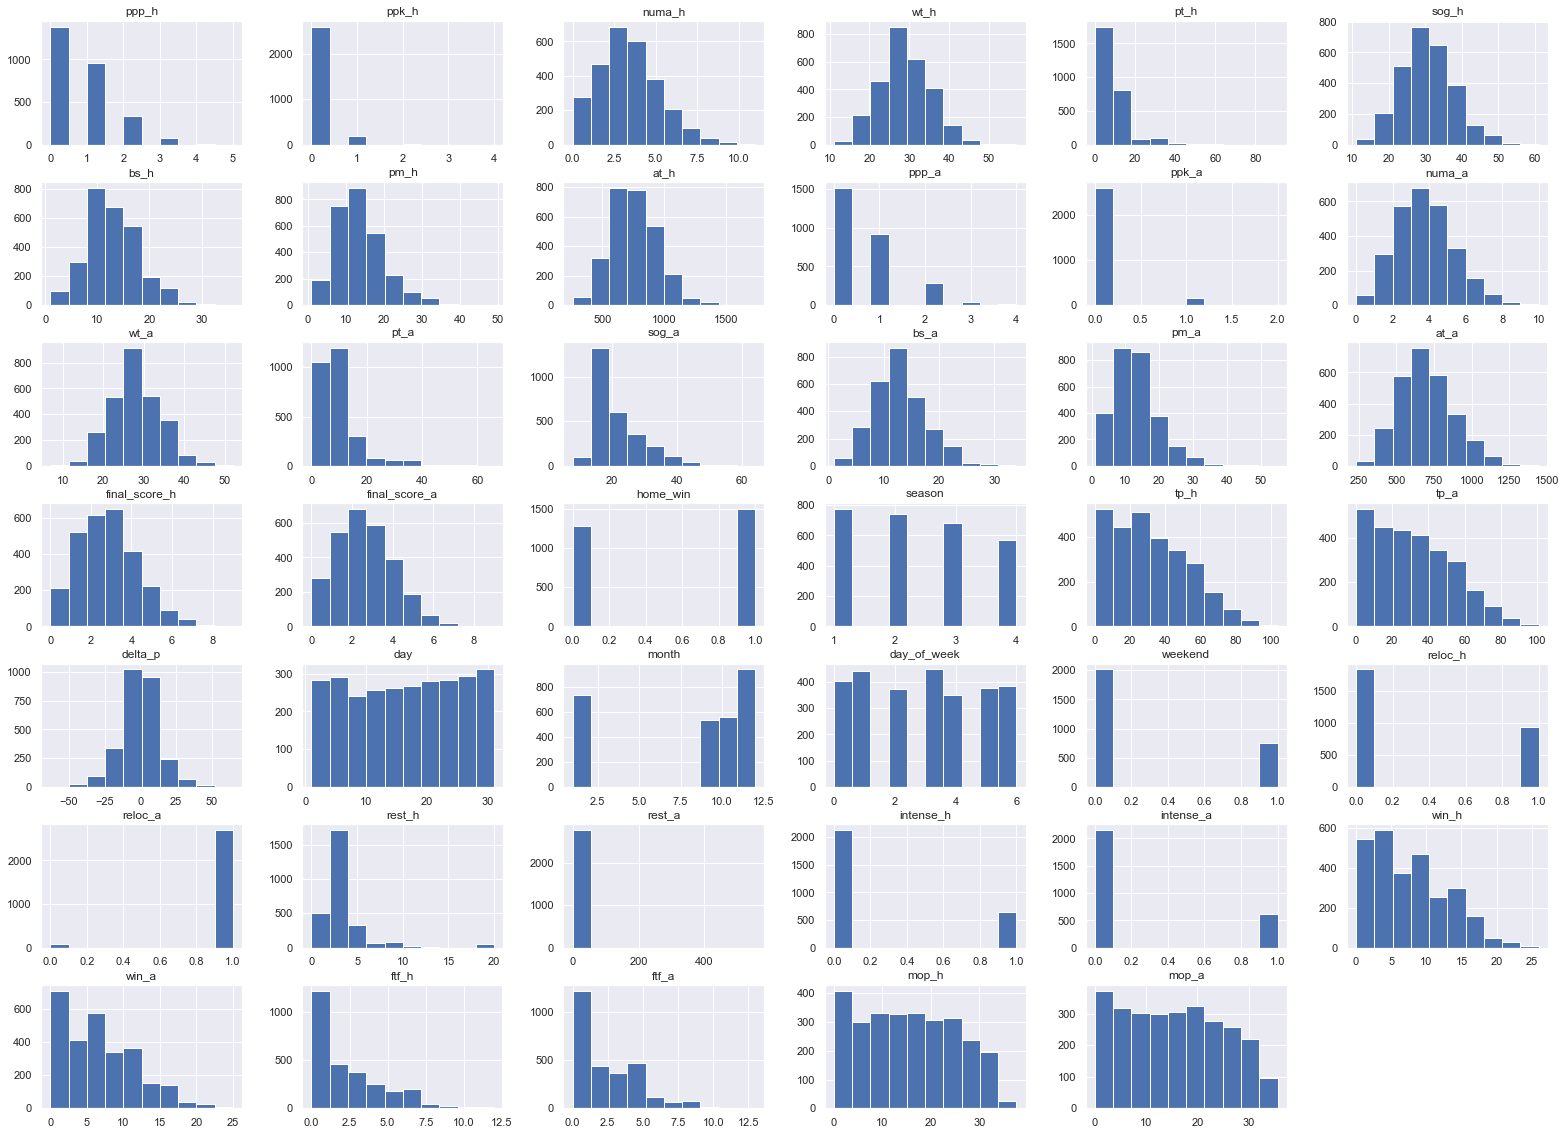

In [91]:
data_sorted_v1.hist(figsize=(27, 20))
plt.show()

In [92]:
features_correlation = pd.DataFrame(columns=['feature_1', 'feature_2', 'correlation_pearson', 'correlation_spearman'])

index = 0

for i in range(3, len(data_sorted_v1.columns)):
    
    for a in range (i+1, len(data_sorted_v1.columns)):
        features_correlation.loc[index, 'feature_1'] = data_sorted_v1.columns[i]
        features_correlation.loc[index, 'feature_2'] = data_sorted_v1.columns[a]
        features_correlation.loc[index, 'correlation_pearson'] = data_sorted_v1[data_sorted_v1.columns[i]].corr(data_sorted_v1[data_sorted_v1.columns[a]], method='pearson')
        features_correlation.loc[index, 'correlation_spearman'] = data_sorted_v1[data_sorted_v1.columns[i]].corr(data_sorted_v1[data_sorted_v1.columns[a]], method='spearman')
        index += 1
                                                                                            
features_correlation[(features_correlation['correlation_pearson'] > 0.7) & (features_correlation['correlation_spearman'] > 0.7)]

,feature_1,feature_2,correlation_pearson,correlation_spearman
609,tp_h,tp_a,0.790787,0.832102
621,tp_h,win_h,0.964451,0.965595
622,tp_h,win_a,0.706372,0.7568
625,tp_h,mop_h,0.876985,0.898124
626,tp_h,mop_a,0.877439,0.898332
638,tp_a,win_h,0.764459,0.804774
639,tp_a,win_a,0.948535,0.951379
642,tp_a,mop_h,0.884905,0.904519
643,tp_a,mop_a,0.883954,0.902572
689,day_of_week,weekend,0.794524,0.781223


Зависимости между очками играющих команд нет (признаки `tp_h, tp_a`) - сильная корелляция объясняется набором очков по ходу сезона. Тем же объясняется сильная корелляция в комбинациях признаков `tp`, `win` и `mop`.
Указанные пары признаков оставляем.

Между днем недели и наличием выходного (признаки `day_of_week, weekend`) связь очевидна - признак `weekend` удаляем.

In [93]:
data_sorted_v1.drop(columns='weekend', inplace=True)

Проверяем датасет на выбросы.

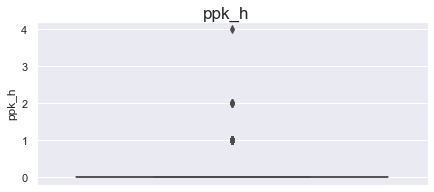

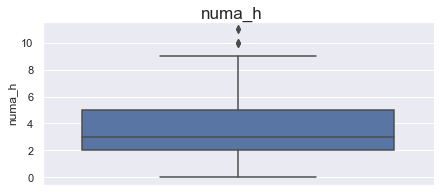

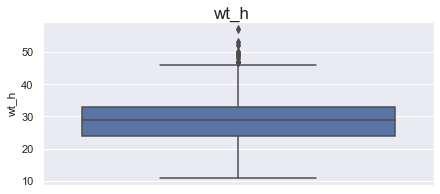

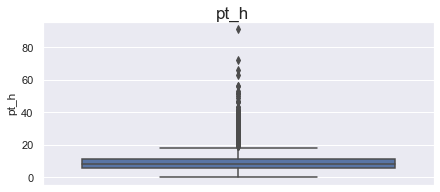

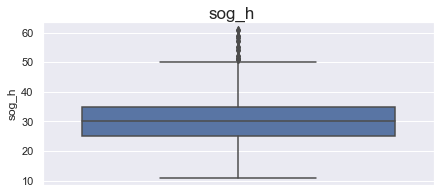

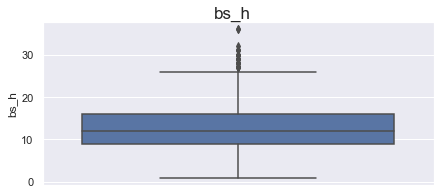

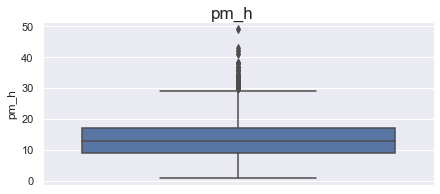

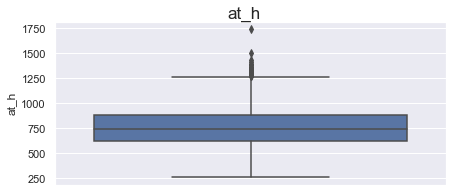

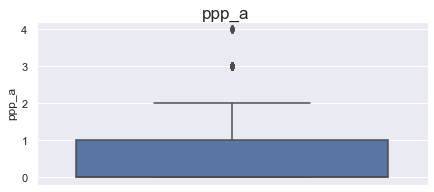

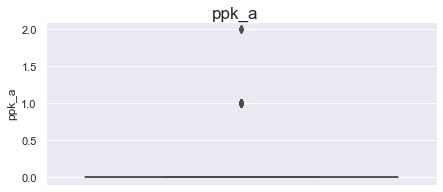

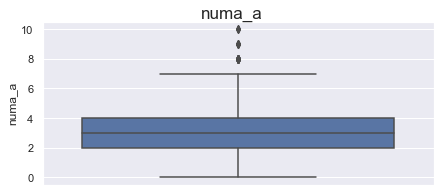

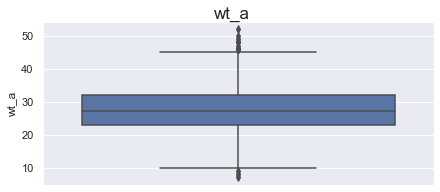

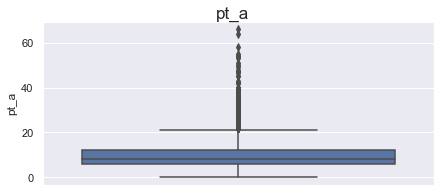

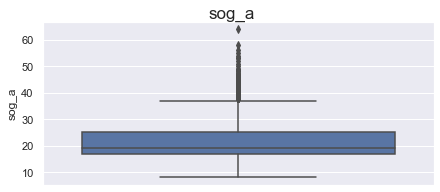

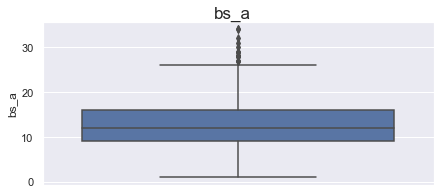

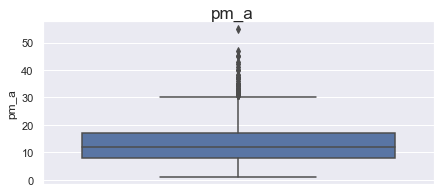

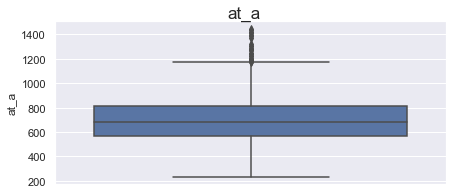

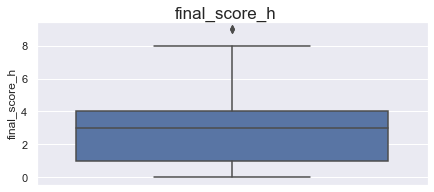

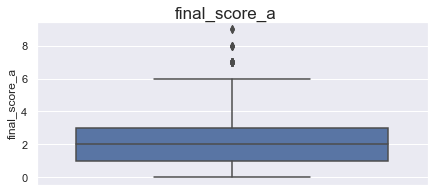

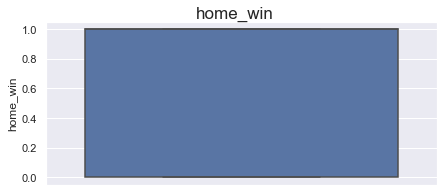

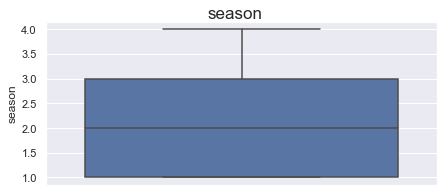

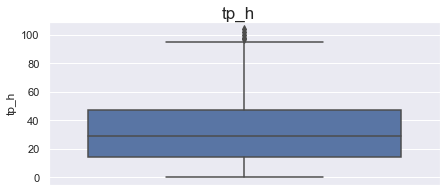

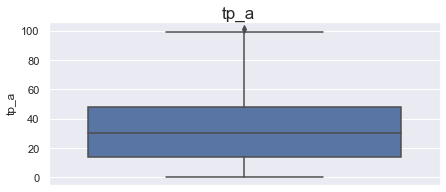

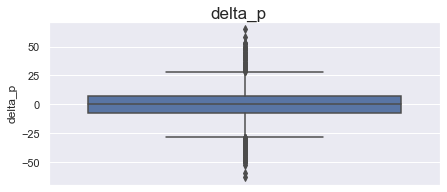

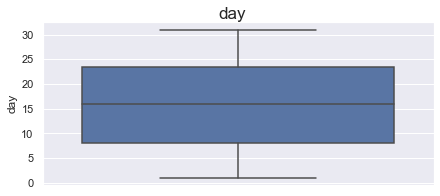

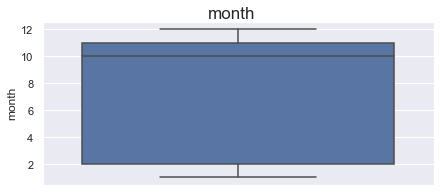

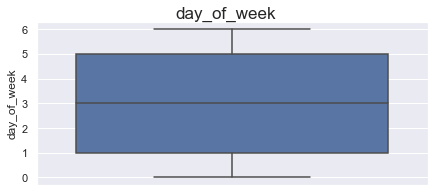

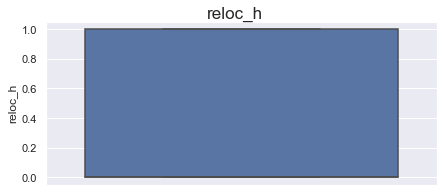

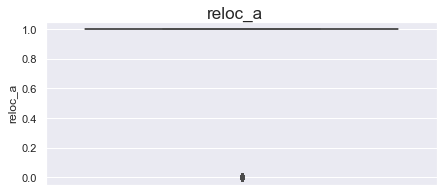

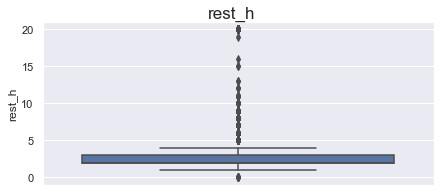

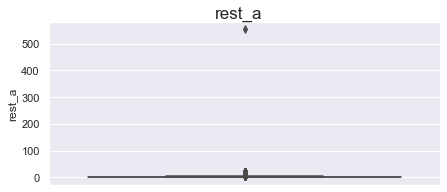

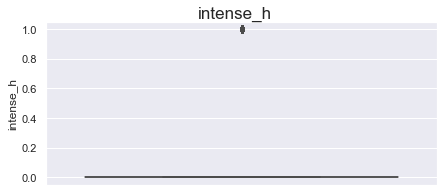

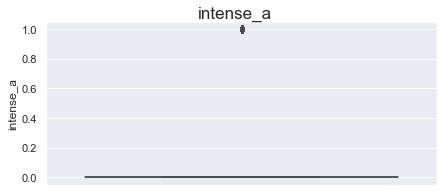

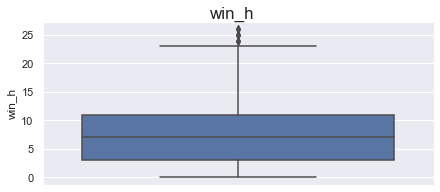

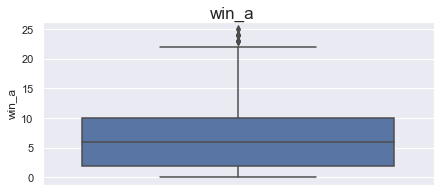

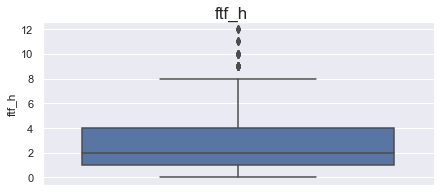

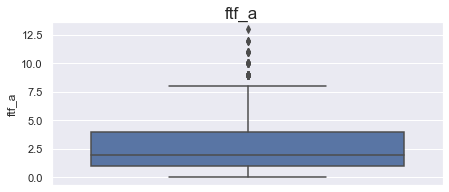

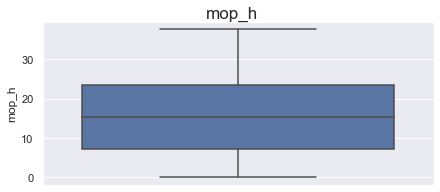

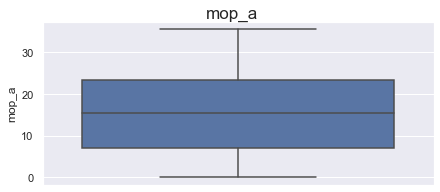

In [94]:
for column in data_sorted_v1.columns[-(len(data_sorted_v1.columns) - 3):]:
    sns.boxplot(y=data_sorted_v1[column])
    sns.set(rc={'figure.figsize':(7, 3)})
    plt.suptitle(column, fontsize=17, y=0.95)
    plt.show()

Проведена проверка матчей на наличие выбросов, аномалий и ошибок:  
- в матче с `ppk_h` равным 4 - ошибка, все шайбы заброшены в равных составах.
- в матче с `at_h` равным 1740 - ошибка, во втором периоде у домашней команды время владения шайбой в атаке составило 19:52 и является нереальным значением. Макс время в атаке за весь матч у игрока данной команды составляет 17:22, т.е. вероятное время в атаке команды во 2м периоде составляет 9:52 - значение 'at_h' скорректировано с учетом данной информации.
- в матче с `rest_a` равным 554 - значение появилось из-за отсутствия команды "Адмирал" в 3 сезоне. Заменяем значение на 20.

In [95]:
data_sorted_v1.loc[data_sorted_v1[data_sorted_v1['ppk_h'] == 4].index, 'ppk_h'] = 0
data_sorted_v1.loc[data_sorted_v1[data_sorted_v1['at_h'] == 1740].index, 'at_h'] = 1140
data_sorted_v1.loc[data_sorted_v1[data_sorted_v1['rest_a'] == 554].index, 'rest_a'] = 20

## <font color='Bisque'> 3. Modeling

<pre>
Частью данной работы является исследование влияния вариантов формирования датасета на качество обучаемых моделей. 
В качестве данных для обучения моделей будет информация по предшествующим матчам играющих команд. 
Т.к. по ходу сезона форма команд меняется, брать в расчет большое кол-во предшествующих игр нецелесообразно - их кол-во будет 1, 3, и 5:

1. при 1 матче будет 3 датасета:
      - 1 из статистики каждой команды в предшествующем матче                                   - датасет df_1
      - 1 из разности статистики рассматриваемой команды и её оппонента                         - датасет df_2
      - 1 из разницы разностей статистики играющих команд                                       - датасет df_3
2. при 3 матчах будет 6 датасетов:
      - 2 из средней и медианной статистики каждой команды в 3 предшествующих матчах            - датасеты df_4 и df_5 соответственно
      - 2 из средней и медианной разности статистики в 3 предшествующих матчах                  - датасеты df_6 и df_7 соответственно
      - 2 из средней и медианной разницы разностей статистики в 3 предшествующих матчах         - датасеты df_8 и df_9 соответственно
3. при 5 матчах будет 6 датасетов:
      - 2 из средней и медианной статистики каждой команды в 5 предшествующих матчах            - датасеты df_10 и df_11 соответственно
      - 2 из средней и медианной разности статистики в 5 предшествующих матчах                  - датасеты df_12 и df_13 соответственно
      - 2 из средней и медианной разницы разностей статистики в 5 предшествующих матчах         - датасеты df_14 и df_15 соответственно

Пишем функцию по формированию нужных типов датасетов с нормализацией циклических временных значений через sin и cos, разделением на обучающую, тестовую выборки и делением их на обучающие и целевой признаки
</pre>

In [96]:
# df                    - исходный датасет
# match_count           - кол-во матчей, которые берутся в расчёт
# type_of_calculation   - тип расчета (None - в расчёт берется исходная статистика, 'diff' - разность статистики для каждой команды по предыдущим матчам, 'diff_diff' - разница разностей статистики для каждой команды по предыдущим матчам)
# mean_median           - опция расчета среднего или медианы по нескольким матчам (доступна для кол-ва матчей 3 и 5)

# в дальнейшем для эксперимента взять в расчет во всех 15 вариантах df всю статистику (в том числе до матча - tp_h и т.д.) - задублировать столбцы 

def df_creator(df, match_count, type_of_calculation=None, mean_median=None):

    # делаем копию исходного датасет для трансформации
    df_main = df.copy()

    if type_of_calculation == None:

        # определяем столбцы для сдвига и вставки у домашней команды
        columns_to_shift_paste_h = ['ppp_h', 'ppk_h', 'numa_h', 'wt_h', 'pt_h', 'sog_h', 'bs_h', 'pm_h', 'at_h', 'final_score_h']
        # определяем столбцы для сдвига и вставки у гостевой команды
        columns_to_shift_paste_a = ['ppp_a', 'ppk_a', 'numa_a', 'wt_a', 'pt_a', 'sog_a', 'bs_a', 'pm_a', 'at_a', 'final_score_a']

    elif type_of_calculation == 'diff' or type_of_calculation == 'diff_diff':
        
        column_prefix = ['ppp', 'ppk', 'numa', 'wt', 'pt', 'sog', 'bs', 'pm', 'at', 'final_score', 'tp', 'reloc', 'rest', 'intense', 'win', 'ftf', 'mop']
        columns_to_shift_paste_h, columns_to_shift_paste_a = [], []

        # считаем разности статистик, которые будут сдвигаться
        for pref in column_prefix[:10]:
            df_main['d_' + pref + '_h'] = df_main[pref + '_h'] - df_main[pref + '_a']
            df_main['d_' + pref + '_a'] = df_main[pref + '_a'] - df_main[pref + '_h']
            df_main.drop(columns=[pref + '_h', pref + '_a'], inplace=True)

            # определяем столбцы для сдвига и вставки у домашней команды
            columns_to_shift_paste_h.append('d_' + pref + '_h')
            # определяем столбцы для сдвига и вставки у гостевой команды
            columns_to_shift_paste_a.append('d_' + pref + '_a')

    else:
        raise TypeError(f'Type of calculation "{type_of_calculation}" does not exist')


    def stat_shifter(team, df_team, columns_to_shift_paste):

        # определяем группу статистик (домашнаяя или гостевая), которые будут рассчитываться для команды
        if 'ppp_h' in columns_to_shift_paste or 'd_ppp_h' in columns_to_shift_paste:
            sec_columns_set = columns_to_shift_paste_a
            home_away_team = 'team_h'
            
        else:
            sec_columns_set = columns_to_shift_paste_h
            home_away_team = 'team_a'

        if match_count == 1 and mean_median == None:

            df_main.loc[df_team.index, columns_to_shift_paste] = np.where  (                
                                                                            (df_main.loc[df_team.index, [home_away_team]*10] == team),
                                                                            df_team.drop(columns=['season']).shift(),
                                                                            df_main.loc[df_team.index, columns_to_shift_paste]
                                                                            )

        elif (match_count == 3 or match_count == 5) and mean_median == 'mean':

            df_main.loc[df_team.index, columns_to_shift_paste] = np.where  (                
                                                                            (df_main.loc[df_team.index, [home_away_team]*10] == team),
                                                                            df_team.drop(columns=['season']).rolling(window=match_count).mean().shift(),
                                                                            df_main.loc[df_team.index, columns_to_shift_paste]
                                                                            )

        elif (match_count == 3 or match_count == 5) and mean_median == 'median':

            df_main.loc[df_team.index, columns_to_shift_paste] = np.where  (                
                                                                            (df_main.loc[df_team.index, [home_away_team]*10] == team),
                                                                            df_team.drop(columns=['season']).rolling(window=match_count).median().shift(),
                                                                            df_main.loc[df_team.index, columns_to_shift_paste]
                                                                            )

        else:
            raise TypeError(f'Parameter mean_median with value "{mean_median}" does not exist, match count ({match_count}) is not set correctly (must be 1, 3 or 5) or their combination is set incorrectly')


    for team in df_main.team_h.unique():

        # создаем отдельный датасет с матчами рассматриваемой команды
        df_team = df_main[(df_main['team_h'] == team) | (df_main['team_a'] == team)]

        # оставляем только статистику рассматриваемой команды
        df_team.drop(columns=['home_win', 'tp_h', 'tp_a', 'delta_p', 'day', 'month',
            'day_of_week', 'reloc_h', 'reloc_a', 'rest_h', 'rest_a', 'intense_h',
            'intense_a', 'win_h', 'win_a', 'ftf_h', 'ftf_a', 'mop_h', 'mop_a'], inplace=True)

        columns_h = ['ppp_h', 'ppk_h', 'numa_h', 'wt_h', 'pt_h', 'sog_h', 'bs_h', 'pm_h', 'at_h', 'final_score_h']
        columns_a = ['ppp_a', 'ppk_a', 'numa_a', 'wt_a', 'pt_a', 'sog_a', 'bs_a', 'pm_a', 'at_a', 'final_score_a']

        df_team[columns_to_shift_paste_h] = np.where(df_team[['team_a'] * 10] == team, df_team[columns_to_shift_paste_a], df_team[columns_to_shift_paste_h])
        df_team.drop(columns=columns_to_shift_paste_a + ['team_h', 'team_a'], inplace=True)

        stat_shifter(team, df_team, columns_to_shift_paste_h)
        stat_shifter(team, df_team, columns_to_shift_paste_a)
    
        # метим кол-во матчей, на которое производится сдвиг, по каждому сезону у всех команд для последующего удаления
        index_first_games = df_team[((df_team.season - df_team.season.shift(match_count)).isna()) | ((df_team.season - df_team.season.shift(match_count)) > 0)].index
        for i in index_first_games:
                if df_main.loc[i, 'team_h'] == team:
                        df_main.loc[i, 'team_h'] = np.nan
                else: df_main.loc[i, 'team_a'] = np.nan

    # удаляем первые матчи команд
    df_main.dropna(subset=['team_h', 'team_a'], inplace=True)

    # считаем разницу разностей между статистиками играющих команд для 3 типа датасетов
    if type_of_calculation == 'diff_diff':

        for pref in column_prefix[:10]:
            df_main['dd_' + pref + '_ha'] = df_main['d_' + pref + '_h'] - df_main['d_' + pref + '_a']
            df_main.drop(columns=['d_' + pref + '_h', 'd_' + pref + '_a'], inplace=True)
        
        for pref in column_prefix[-7:]:
            df_main['dd_' + pref + '_ha'] = df_main[pref + '_h'] - df_main[pref + '_a']
            df_main.drop(columns=[pref + '_h', pref + '_a'], inplace=True)

        df_main.drop(columns=['delta_p'], inplace=True)

    else:
        pass

    # приводим к сопоставимой значимости циклические временные значения (`'day', 'month', 'day_of_week'`) с помощью тригонометрических функций. Используем sin и cos, чтобы они уравновешивали друг друга и не было перекоса в данных.
    df_main['day_of_week_cos'], df_main['day_of_week_sin'] = np.cos(2 * np.pi * df_main['day_of_week'] / 6), np.sin(2 * np.pi * df_main['day_of_week'] / 6)
    df_main['month_cos'], df_main['month_sin'] = np.cos(2 * np.pi * df_main['month'] / 12), np.sin(2 * np.pi * df_main['month'] / 12)
    df_main['day_cos'], df_main['day_sin'] = np.cos(2 * np.pi * df_main['day'] / 31), np.sin(2 * np.pi * df_main['day'] / 31)

    # удаляем более не нужные столбцы
    df_main.drop(columns=['team_h', 'team_a', 'day', 'day_of_week', 'month'], inplace=True)

    # делим датасет на обучающую и тестовую выборки
    df_train, df_test = df_main[df_main.season < 4], df_main[df_main.season == 4]
    # удаляем ненужный столбец season
    df_train.drop(columns=['season'], inplace=True)
    df_test.drop(columns=['season'], inplace=True)

    x_train, y_train = df_train.drop(columns=['home_win']), df_train['home_win']
    x_test, y_test = df_test.drop(columns=['home_win']), df_test['home_win']

    return x_train, y_train, x_test, y_test

Создаем датасеты необходимого формата

In [97]:
df_1_x_train, df_1_y_train, df_1_x_test, df_1_y_test = df_creator(data_sorted_v1, 1, type_of_calculation=None, mean_median=None)
df_2_x_train, df_2_y_train, df_2_x_test, df_2_y_test = df_creator(data_sorted_v1, 1, type_of_calculation='diff', mean_median=None)
df_3_x_train, df_3_y_train, df_3_x_test, df_3_y_test = df_creator(data_sorted_v1, 1, type_of_calculation='diff_diff', mean_median=None)

df_4_x_train, df_4_y_train, df_4_x_test, df_4_y_test = df_creator(data_sorted_v1, 3, type_of_calculation=None, mean_median='mean')
df_5_x_train, df_5_y_train, df_5_x_test, df_5_y_test = df_creator(data_sorted_v1, 3, type_of_calculation=None, mean_median='median')
df_6_x_train, df_6_y_train, df_6_x_test, df_6_y_test = df_creator(data_sorted_v1, 3, type_of_calculation='diff', mean_median='mean')
df_7_x_train, df_7_y_train, df_7_x_test, df_7_y_test = df_creator(data_sorted_v1, 3, type_of_calculation='diff', mean_median='median')
df_8_x_train, df_8_y_train, df_8_x_test, df_8_y_test = df_creator(data_sorted_v1, 3, type_of_calculation='diff_diff', mean_median='mean')
df_9_x_train, df_9_y_train, df_9_x_test, df_9_y_test = df_creator(data_sorted_v1, 3, type_of_calculation='diff_diff', mean_median='median')

df_10_x_train, df_10_y_train, df_10_x_test, df_10_y_test = df_creator(data_sorted_v1, 5, type_of_calculation=None, mean_median='mean')
df_11_x_train, df_11_y_train, df_11_x_test, df_11_y_test = df_creator(data_sorted_v1, 5, type_of_calculation=None, mean_median='median')
df_12_x_train, df_12_y_train, df_12_x_test, df_12_y_test = df_creator(data_sorted_v1, 5, type_of_calculation='diff', mean_median='mean')
df_13_x_train, df_13_y_train, df_13_x_test, df_13_y_test = df_creator(data_sorted_v1, 5, type_of_calculation='diff', mean_median='median')
df_14_x_train, df_14_y_train, df_14_x_test, df_14_y_test = df_creator(data_sorted_v1, 5, type_of_calculation='diff_diff', mean_median='mean')
df_15_x_train, df_15_y_train, df_15_x_test, df_15_y_test = df_creator(data_sorted_v1, 5, type_of_calculation='diff_diff', mean_median='median')

In [98]:
df_dict = { '1':[df_1_x_train, df_1_y_train, df_1_x_test, df_1_y_test], '2':[df_2_x_train, df_2_y_train, df_2_x_test, df_2_y_test],
            '3':[df_3_x_train, df_3_y_train, df_3_x_test, df_3_y_test], '4':[df_4_x_train, df_4_y_train, df_4_x_test, df_4_y_test],
            '5':[df_5_x_train, df_5_y_train, df_5_x_test, df_5_y_test], '6':[df_6_x_train, df_6_y_train, df_6_x_test, df_6_y_test],
            '7':[df_7_x_train, df_7_y_train, df_7_x_test, df_7_y_test], '8':[df_8_x_train, df_8_y_train, df_8_x_test, df_8_y_test],
            '9':[df_9_x_train, df_9_y_train, df_9_x_test, df_9_y_test], '10':[df_10_x_train, df_10_y_train, df_10_x_test, df_10_y_test],
            '11':[df_11_x_train, df_11_y_train, df_11_x_test, df_11_y_test], '12':[df_12_x_train, df_12_y_train, df_12_x_test, df_12_y_test],
            '13':[df_13_x_train, df_13_y_train, df_13_x_test, df_13_y_test], '14':[df_14_x_train, df_14_y_train, df_14_x_test, df_14_y_test],
            '15':[df_15_x_train, df_15_y_train, df_15_x_test, df_15_y_test]
            }

df_list_names, shapes = [], []

for i in range(1,16):
    df_list_names.append(f'df_{i}_x_train')
    df_list_names.append(f'df_{i}_y_train')
    df_list_names.append(f'df_{i}_x_test')
    df_list_names.append(f'df_{i}_y_test')

    shapes.append(df_dict[str(i)][0].shape)
    shapes.append(df_dict[str(i)][1].shape)
    shapes.append(df_dict[str(i)][2].shape)
    shapes.append(df_dict[str(i)][3].shape)

df_info = pd.DataFrame(index=df_list_names, columns=['rows', 'columns'], data=shapes)
df_info = df_info.fillna(1)
df_info

,rows,columns
df_1_x_train,2161,41.0
df_1_y_train,2161,1.0
df_1_x_test,560,41.0
df_1_y_test,560,1.0
df_2_x_train,2161,41.0
df_2_y_train,2161,1.0
df_2_x_test,560,41.0
df_2_y_test,560,1.0
df_3_x_train,2161,23.0
df_3_y_train,2161,1.0


In [99]:
print('Обучающие и тестовые выборки по вариантам формирования датасетов с принятием в расчет 1 предшествующего матча разделены в соотношении {:.0%} / {:.0%}'.format(
    (1-df_1_x_test.shape[0]/df_1_x_train.shape[0]), (df_1_x_test.shape[0]/df_1_x_train.shape[0])), end='\n\n')
print('Обучающие и тестовые выборки по вариантам формирования датасетов с принятием в расчет 3 предшествующих матчей разделены в соотношении {:.0%} / {:.0%}'.format(
    (1-df_4_x_test.shape[0]/df_4_x_train.shape[0]), (df_4_x_test.shape[0]/df_4_x_train.shape[0])), end='\n\n')
print('Обучающие и тестовые выборки по вариантам формирования датасетов с принятием в расчет 5 предшествующих матчей разделены в соотношении {:.0%} / {:.0%}'.format(
    (1-df_10_x_test.shape[0]/df_10_x_train.shape[0]), (df_10_x_test.shape[0]/df_10_x_train.shape[0])))

Обучающие и тестовые выборки по вариантам формирования датасетов с принятием в расчет 1 предшествующего матча разделены в соотношении 74% / 26%

Обучающие и тестовые выборки по вариантам формирования датасетов с принятием в расчет 3 предшествующих матчей разделены в соотношении 74% / 26%

Обучающие и тестовые выборки по вариантам формирования датасетов с принятием в расчет 5 предшествующих матчей разделены в соотношении 75% / 25%


Перед обучением моделей нужно нормализовать данные, не относящиеся к категориальным признакам. Нормализация, также как и формирование датасетов, будет вариативным. На каждом датасете будет применено 3 варианта нормализации:

- минимакс (MinMaxScaler)
- стандартизация (StandardScaler)
- нормализация (Normalizer)

Напишем функцию по процессу нормализации

In [100]:
def normalizer(df_train, df_test):

    cat_columns = ['reloc_h', 'reloc_a', 'intense_h', 'intense_a']
    time_columns = ['day_of_week_cos', 'day_of_week_sin', 'month_cos', 'month_sin', 'day_cos', 'day_sin']
    
    # убираем из нормализуемых датасетов категориальные признаки (присутствуют не во всех датасетах) и смаштабированные временные значения

    try:
        df_train_wo_cat_mm, df_train_wo_cat_st, df_train_wo_cat_norm = df_train.drop(columns=cat_columns+time_columns), df_train.drop(columns=cat_columns+time_columns), df_train.drop(columns=cat_columns+time_columns)
        df_test_wo_cat_mm, df_test_wo_cat_st, df_test_wo_cat_norm = df_test.drop(columns=cat_columns+time_columns), df_test.drop(columns=cat_columns+time_columns), df_test.drop(columns=cat_columns+time_columns)

        i = 0

    except KeyError:
        df_train_wo_cat_mm, df_train_wo_cat_st, df_train_wo_cat_norm = df_train.drop(columns=time_columns), df_train.drop(columns=time_columns), df_train.drop(columns=time_columns)
        df_test_wo_cat_mm, df_test_wo_cat_st, df_test_wo_cat_norm = df_test.drop(columns=time_columns), df_test.drop(columns=time_columns), df_test.drop(columns=time_columns)

        i = 1


    mm_scaler = MinMaxScaler()
    df_train_wo_cat_mm.loc[:, :] = mm_scaler.fit_transform(df_train_wo_cat_mm)
    df_test_wo_cat_mm.loc[:, :] = mm_scaler.transform(df_test_wo_cat_mm)    

    st_scaler = StandardScaler()
    df_train_wo_cat_st.loc[:, :] = st_scaler.fit_transform(df_train_wo_cat_st)
    df_test_wo_cat_st.loc[:, :] = st_scaler.transform(df_test_wo_cat_st)

    # код скорректирован для учета особенностей работы нормалайзера (масштабирование по строкам) - сначала объединяем train и test, совместно нормализуем, потом разбиваем на train и test
    norm_scaler = Normalizer()
    index = min(df_test.index)
    df_train_test_wo_cat_norm = pd.concat([df_train_wo_cat_norm, df_test_wo_cat_norm])
    df_train_test_wo_cat_norm = df_train_test_wo_cat_norm.transpose()
    df_train_test_wo_cat_norm.loc[:, :] = norm_scaler.fit_transform(df_train_test_wo_cat_norm)
    df_train_test_wo_cat_norm = df_train_test_wo_cat_norm.transpose()
    df_train_wo_cat_norm = df_train_test_wo_cat_norm[df_train_test_wo_cat_norm.index < index]
    df_test_wo_cat_norm = df_train_test_wo_cat_norm[df_train_test_wo_cat_norm.index >= index]

    
    # добавляем к нормализованным данным категориальные признаки (если имеются) и смаштабированные временные значения
    if i == 0:

        df_train_mm = pd.merge(df_train_wo_cat_mm, df_train[cat_columns+time_columns], left_index=True, right_index=True)
        df_test_mm = pd.merge(df_test_wo_cat_mm, df_test[cat_columns+time_columns], left_index=True, right_index=True)

        df_train_st = pd.merge(df_train_wo_cat_st, df_train[cat_columns+time_columns], left_index=True, right_index=True)
        df_test_st = pd.merge(df_test_wo_cat_st, df_test[cat_columns+time_columns], left_index=True, right_index=True)

        df_train_norm = pd.merge(df_train_wo_cat_norm, df_train[cat_columns+time_columns], left_index=True, right_index=True)
        df_test_norm = pd.merge(df_test_wo_cat_norm, df_test[cat_columns+time_columns], left_index=True, right_index=True)

    else:
        df_train_mm = pd.merge(df_train_wo_cat_mm, df_train[time_columns], left_index=True, right_index=True)
        df_test_mm = pd.merge(df_test_wo_cat_mm, df_test[time_columns], left_index=True, right_index=True)

        df_train_st = pd.merge(df_train_wo_cat_st, df_train[time_columns], left_index=True, right_index=True)
        df_test_st = pd.merge(df_test_wo_cat_st, df_test[time_columns], left_index=True, right_index=True)

        df_train_norm = pd.merge(df_train_wo_cat_norm, df_train[time_columns], left_index=True, right_index=True)
        df_test_norm = pd.merge(df_test_wo_cat_norm, df_test[time_columns], left_index=True, right_index=True)


    return df_train_mm, df_train_st, df_train_norm, df_test_mm, df_test_st, df_test_norm

Масштабируем все имеющиеся датасеты с обучающими признаками

In [101]:
df_1_x_train_mm, df_1_x_train_st, df_1_x_train_norm, df_1_x_test_mm, df_1_x_test_st, df_1_x_test_norm = normalizer(df_1_x_train, df_1_x_test)
df_2_x_train_mm, df_2_x_train_st, df_2_x_train_norm, df_2_x_test_mm, df_2_x_test_st, df_2_x_test_norm = normalizer(df_2_x_train, df_2_x_test)
df_3_x_train_mm, df_3_x_train_st, df_3_x_train_norm, df_3_x_test_mm, df_3_x_test_st, df_3_x_test_norm = normalizer(df_3_x_train, df_3_x_test)
df_4_x_train_mm, df_4_x_train_st, df_4_x_train_norm, df_4_x_test_mm, df_4_x_test_st, df_4_x_test_norm = normalizer(df_4_x_train, df_4_x_test)
df_5_x_train_mm, df_5_x_train_st, df_5_x_train_norm, df_5_x_test_mm, df_5_x_test_st, df_5_x_test_norm = normalizer(df_5_x_train, df_5_x_test)
df_6_x_train_mm, df_6_x_train_st, df_6_x_train_norm, df_6_x_test_mm, df_6_x_test_st, df_6_x_test_norm = normalizer(df_6_x_train, df_6_x_test)
df_7_x_train_mm, df_7_x_train_st, df_7_x_train_norm, df_7_x_test_mm, df_7_x_test_st, df_7_x_test_norm = normalizer(df_7_x_train, df_7_x_test)
df_8_x_train_mm, df_8_x_train_st, df_8_x_train_norm, df_8_x_test_mm, df_8_x_test_st, df_8_x_test_norm = normalizer(df_8_x_train, df_8_x_test)
df_9_x_train_mm, df_9_x_train_st, df_9_x_train_norm, df_9_x_test_mm, df_9_x_test_st, df_9_x_test_norm = normalizer(df_9_x_train, df_9_x_test)
df_10_x_train_mm, df_10_x_train_st, df_10_x_train_norm, df_10_x_test_mm, df_10_x_test_st, df_10_x_test_norm = normalizer(df_10_x_train, df_10_x_test)
df_11_x_train_mm, df_11_x_train_st, df_11_x_train_norm, df_11_x_test_mm, df_11_x_test_st, df_11_x_test_norm = normalizer(df_11_x_train, df_11_x_test)
df_12_x_train_mm, df_12_x_train_st, df_12_x_train_norm, df_12_x_test_mm, df_12_x_test_st, df_12_x_test_norm = normalizer(df_12_x_train, df_12_x_test)
df_13_x_train_mm, df_13_x_train_st, df_13_x_train_norm, df_13_x_test_mm, df_13_x_test_st, df_13_x_test_norm = normalizer(df_13_x_train, df_13_x_test)
df_14_x_train_mm, df_14_x_train_st, df_14_x_train_norm, df_14_x_test_mm, df_14_x_test_st, df_14_x_test_norm = normalizer(df_14_x_train, df_14_x_test)
df_15_x_train_mm, df_15_x_train_st, df_15_x_train_norm, df_15_x_test_mm, df_15_x_test_st, df_15_x_test_norm = normalizer(df_15_x_train, df_15_x_test)


total_df_dict = {
                '1':[[df_1_x_train_mm, df_1_y_train, df_1_x_test_mm, df_1_y_test], [df_1_x_train_st, df_1_x_test_st], [df_1_x_train_norm, df_1_x_test_norm]],
                '2':[[df_2_x_train_mm, df_2_y_train, df_2_x_test_mm, df_2_y_test], [df_2_x_train_st, df_2_x_test_st], [df_2_x_train_norm, df_2_x_test_norm]],
                '3':[[df_3_x_train_mm, df_3_y_train, df_3_x_test_mm, df_3_y_test], [df_3_x_train_st, df_3_x_test_st], [df_3_x_train_norm, df_3_x_test_norm]],
                '4':[[df_4_x_train_mm, df_4_y_train, df_4_x_test_mm, df_4_y_test], [df_4_x_train_st, df_4_x_test_st], [df_4_x_train_norm, df_4_x_test_norm]],
                '5':[[df_5_x_train_mm, df_5_y_train, df_5_x_test_mm, df_5_y_test], [df_5_x_train_st, df_5_x_test_st], [df_5_x_train_norm, df_5_x_test_norm]],
                '6':[[df_6_x_train_mm, df_6_y_train, df_6_x_test_mm, df_6_y_test], [df_6_x_train_st, df_6_x_test_st], [df_6_x_train_norm, df_6_x_test_norm]],
                '7':[[df_7_x_train_mm, df_7_y_train, df_7_x_test_mm, df_7_y_test], [df_7_x_train_st, df_7_x_test_st], [df_7_x_train_norm, df_7_x_test_norm]],
                '8':[[df_8_x_train_mm, df_8_y_train, df_8_x_test_mm, df_8_y_test], [df_8_x_train_st, df_8_x_test_st], [df_8_x_train_norm, df_8_x_test_norm]],
                '9':[[df_9_x_train_mm, df_9_y_train, df_9_x_test_mm, df_9_y_test], [df_9_x_train_st, df_9_x_test_st], [df_9_x_train_norm, df_9_x_test_norm]],
                '10':[[df_10_x_train_mm, df_10_y_train, df_10_x_test_mm, df_10_y_test], [df_10_x_train_st, df_10_x_test_st], [df_10_x_train_norm, df_10_x_test_norm]],
                '11':[[df_11_x_train_mm, df_11_y_train, df_11_x_test_mm, df_11_y_test], [df_11_x_train_st, df_11_x_test_st], [df_11_x_train_norm, df_11_x_test_norm]],
                '12':[[df_12_x_train_mm, df_12_y_train, df_12_x_test_mm, df_12_y_test], [df_12_x_train_st, df_12_x_test_st], [df_12_x_train_norm, df_12_x_test_norm]],
                '13':[[df_13_x_train_mm, df_13_y_train, df_13_x_test_mm, df_13_y_test], [df_13_x_train_st, df_13_x_test_st], [df_13_x_train_norm, df_13_x_test_norm]],
                '14':[[df_14_x_train_mm, df_14_y_train, df_14_x_test_mm, df_14_y_test], [df_14_x_train_st, df_14_x_test_st], [df_14_x_train_norm, df_14_x_test_norm]],
                '15':[[df_15_x_train_mm, df_15_y_train, df_15_x_test_mm, df_15_y_test], [df_15_x_train_st, df_15_x_test_st], [df_15_x_train_norm, df_15_x_test_norm]]
                }

In [102]:
print('В обучающих датасетах по вариантам формирования с принятием в расчет 1 предшествующего матча объектов положительного класса - {:.0%}'.format((df_1_y_train == 1).sum()/len(df_1_y_train)), end='\n\n')
print('В обучающих датасетах по вариантам формирования с принятием в расчет 3 предшествующих матчей объектов положительного класса - {:.0%}'.format((df_4_y_train == 1).sum()/len(df_4_y_train)), end='\n\n')
print('В обучающих датасетах по вариантам формирования с принятием в расчет 5 предшествующих матчей объектов положительного класса - {:.0%}'.format((df_10_y_train == 1).sum()/len(df_10_y_train)), end='\n\n')

В обучающих датасетах по вариантам формирования с принятием в расчет 1 предшествующего матча объектов положительного класса - 55%

В обучающих датасетах по вариантам формирования с принятием в расчет 3 предшествующих матчей объектов положительного класса - 54%

В обучающих датасетах по вариантам формирования с принятием в расчет 5 предшествующих матчей объектов положительного класса - 54%



Сильного дисбаланса классов нет. Метрикой качества будет ROC AUC, которая не требует подбора порога для разделения выдаваемых моделью вероятностей.

Для начала определим качество базовых моделей - это будут константные модели с прогнозом победы домашней команды во всех матчах.

In [103]:
df_1_y_baseline = df_1_y_train.replace(0,1)
df_4_y_baseline = df_4_y_train.replace(0,1)
df_10_y_baseline = df_10_y_train.replace(0,1)

print('ROC AUC базовой модели по вариантам формирования датасетов с принятием в расчет 1 предшествующего матча составляет:    {:.2f}'.format(roc_auc_score(df_1_y_train, df_1_y_baseline)), end='\n\n')
print('ROC AUC базовой модели по вариантам формирования датасетов с принятием в расчет 3 предшествующих матчей составляет:    {:.2f}'.format(roc_auc_score(df_4_y_train, df_4_y_baseline)), end='\n\n')
print('ROC AUC базовой модели по вариантам формирования датасетов с принятием в расчет 5 предшествующих матчей составляет:    {:.2f}'.format(roc_auc_score(df_10_y_train, df_10_y_baseline)))

ROC AUC базовой модели по вариантам формирования датасетов с принятием в расчет 1 предшествующего матча составляет:    0.50

ROC AUC базовой модели по вариантам формирования датасетов с принятием в расчет 3 предшествующих матчей составляет:    0.50

ROC AUC базовой модели по вариантам формирования датасетов с принятием в расчет 5 предшествующих матчей составляет:    0.50


Обучаем модели LogisticRegression, RandomForestClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier с различными гиперпараметрами

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# делаем 10 фолдов, т.к. обучающих данных немного
folds = KFold(n_splits=10, shuffle=True, random_state=800)


# LogisticRegression_________________________________________________________________________________________________________________________________________________________________________________________________________________________________
lr_param = [
            {'solver': ['newton-cg'], 'penalty': ['l2', 'none'], 'C': [1e-5, 1e-3, 1e-1, 1, 10], 'max_iter': [100, 500, 1000]},
            {'solver': ['lbfgs'], 'penalty': ['l2', 'none'], 'C': [1e-5, 1e-3, 1e-1, 1, 10], 'max_iter': [100, 500, 1000]},
            {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [1e-5, 1e-3, 1e-1, 1, 10], 'max_iter': [100, 500, 1000], 'random_state': [800]},
            {'solver': ['sag'], 'penalty': ['l2', 'none'], 'C': [1e-5, 1e-3, 1e-1, 1, 10], 'max_iter': [100, 500, 1000], 'random_state': [800]},
            {'solver': ['saga'], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [1e-5, 1e-3, 1e-1, 1, 10], 'max_iter': [100, 500, 1000], 'random_state': [800]}        
            ]

lr_model = LogisticRegression()
lr_model_grid = GridSearchCV(estimator=lr_model,
                            param_grid=lr_param,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=folds,
                            verbose=1,
                            return_train_score=True)


# RandomForestClassifier______________________________________________________________________________________________________________________________________________________________________________________________________________________________
rfc_param = {'n_estimators': [200, 500],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3],
            'max_features': [0.5, 0.7],
            'max_samples': [0.5, 0.7]
            }

rfc_model = RandomForestClassifier(criterion='log_loss', bootstrap=True, random_state=800)
rfc_model_grid = GridSearchCV(estimator=rfc_model,
                            param_grid=rfc_param,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=folds,
                            verbose=1,
                            return_train_score=True)


# XGBClassifier_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________
xgb_param = {'eta': [0.001, 0.01],
            'n_estimators': [200, 500],
            'max_depth': [5, 10],
            'subsample': [0.5, 0.7],
            'min_child_weight': [2, 5],
            'colsample_bytree': [0.5, 0.7]
            }

xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', seed=800)
xgb_model_grid = GridSearchCV(estimator=xgb_model, 
                            param_grid=xgb_param,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=folds,
                            verbose=1,
                            return_train_score=True)


# LGBMClassifier_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________
lgbm_param ={'n_estimators': [200, 500],
            'max_depth': [5, 10],
            'min_data_in_leaf': [5, 10],
            'learning_rate': [0.001, 0.01],
            'subsample': [0.5, 0.7],
            'colsample_bytree': [0.5, 0.7]
            }

lgbm_model = LGBMClassifier(objective='binary', metric='auc', random_state=800)
lgbm_model_grid = GridSearchCV(estimator=lgbm_model,
                                param_grid=lgbm_param,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=folds,
                                verbose=1,
                                return_train_score=True)


# CatBoostClassifier___________________________________________________________________________________________________________________________________________________________________________________________________________________________________
cbc_param = {'iterations': [200, 500],
            'learning_rate': [0.001, 0.01],
            'subsample': [0.5, 0.7],
            'rsm': [0.5, 0.7],
            'depth': [5, 10],
            'min_data_in_leaf': [1, 3]
            }

cbc_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', random_seed=800, verbose=0)
cbc_model_grid = GridSearchCV(estimator=cbc_model,
                                param_grid=cbc_param,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=folds,
                                verbose=1,
                                return_train_score=True)

Для каждого из 15 наборов данных выбираем наилучшую модель

In [150]:
df_scores = pd.DataFrame(index=[index.replace('_x_train', '') for index in df_info.index if '_x_train' in index ], columns=['best_model_mm', 'best_score_mm', 'best_model_st', 'best_score_st','best_model_norm', 'best_score_norm'])
models = [lr_model_grid, rfc_model_grid, xgb_model_grid, lgbm_model_grid, cbc_model_grid]

# функция возвращает строку с лучшей моделью и лучшим качеством для одного датасета
def training(x, y):

    df = pd.DataFrame(columns=['best_model', 'best_score'])

    for model in models:

        model.fit(x, y)
        df = pd.concat([df, pd.DataFrame(columns=['best_model', 'best_score'], data=[[model.best_estimator_, model.best_score_]])], axis=0)

        
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='best_score', ascending=False, inplace=True)
    df.drop(index=df.index[1:], inplace=True)

    return df

for k, v in total_df_dict.items():

    # определяем лучшую модель для mm-датасета
    df_scores.iloc[int(k) - 1, :2] = training(v[0][0], v[0][1])

    # определяем лучшую модель для st-датасета
    df_scores.iloc[int(k) - 1, 2:4] = training(v[1][0], v[0][1])

    # определяем лучшую модель для st-датасета
    df_scores.iloc[int(k) - 1, 4:6] = training(v[2][0], v[0][1])

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Fitting 10 folds for each of 180 candidates, tota

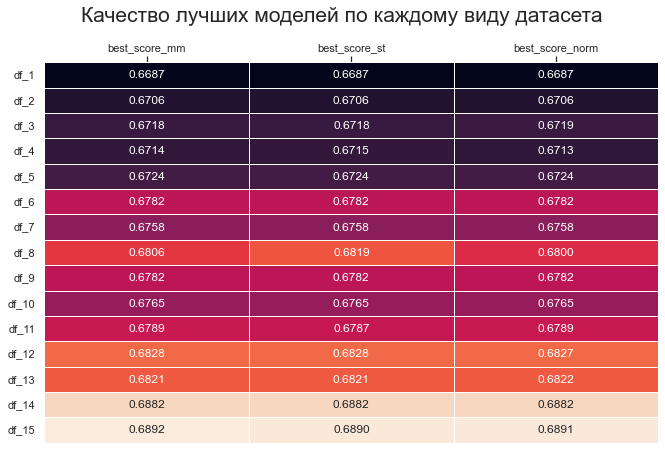

Лучшей по качеству моделью стала: 

 RandomForestClassifier(criterion='log_loss', max_depth=5, max_features=0.7,
                       max_samples=0.5, min_samples_leaf=3, n_estimators=200,
                       random_state=800)


In [155]:
plt.figure(figsize=(11, 7))
plt.suptitle('Качество лучших моделей по каждому виду датасета', fontsize=21, y=0.99)
ax = sns.heatmap(data=df_scores[['best_score_mm', 'best_score_st', 'best_score_norm']].astype('float64'), annot=True, cbar=False, linewidths=.5, fmt= '.4f')
ax.xaxis.tick_top()
plt.show()

print('Лучшей по качеству моделью стала: \n\n {}'.format(df_scores[df_scores.best_score_norm == df_scores.best_score_norm.max()]['best_model_norm'].values.tolist()[0]))

Максимальный полученный ROC AUC составил 0.689 у модели RandomForest на датаcете с смасштабированными минимаксом данными, состоящими из медианной разницы разностей статистики в 5 предшествующих матчах. 

В целом же имеется тенденция к повышению качества моделей при увеличении количества матчей, которые берутся в расчёт.

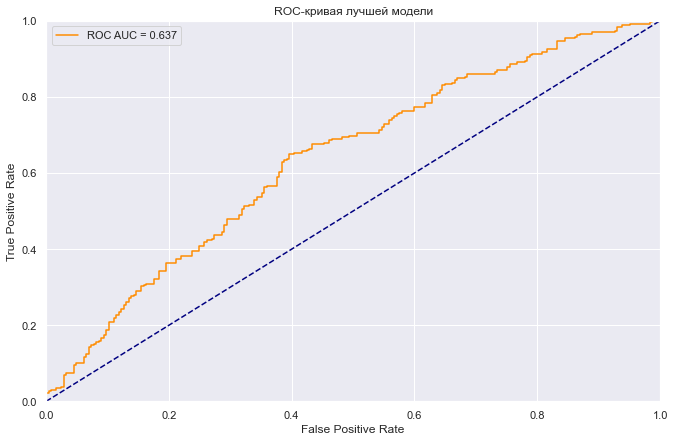

In [152]:
best_model = df_scores[df_scores.best_score_norm == df_scores.best_score_norm.max()]['best_model_norm'].values.tolist()[0].fit(df_14_x_train_norm, df_14_y_train)
# считаем вероятности для классов
probs = best_model.predict_proba(df_14_x_test_norm)

# сохраняем вероятности только для положительного класса
probs = probs[:, 1]

# считаем FPR и TPR, необходимые для построения графика
fpr, tpr, treshold = roc_curve(df_14_y_test, probs)
roc_auc = auc(fpr, tpr)

# строим график
plt.figure(figsize=(11, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая лучшей модели')
plt.legend(loc="upper left")
plt.show()

Модель переобучена - будет чем позаниматься на досуге))

Посмотрим еще на значимость признаков

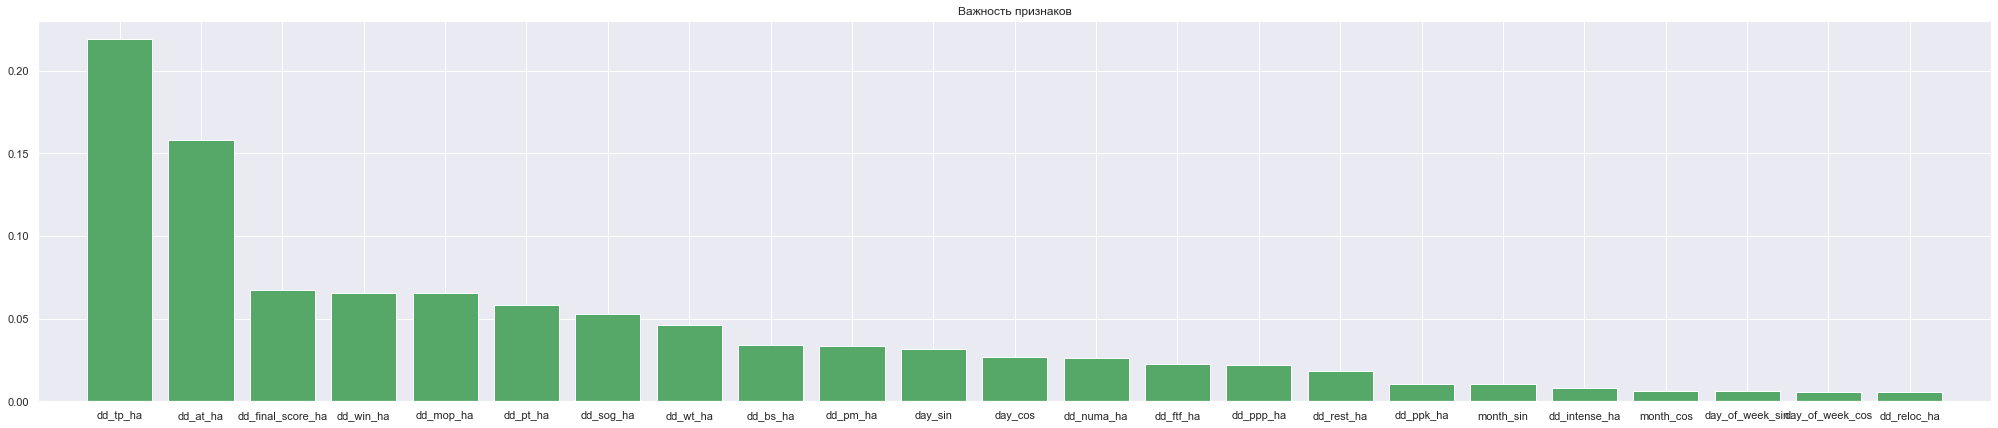

In [153]:
importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(35, 7))
plt.title('Важность признаков')
plt.bar(range(df_14_x_train_norm.shape[1]), importances[indices],
        color="g", align="center")
plt.xticks(range(df_14_x_train_norm.shape[1]), df_14_x_train_norm.columns.array[indices])
plt.xlim([-1, df_14_x_train_norm.shape[1]])
plt.show()

### <font color='Aquamarine'>Лучшей моделью стала RandomForest. Ее значение ROC AUC на обучающих данных составило 0.689, на тестовых - 0.637. Наиболее значимыми признаками являются разность очков играющих команд и разность времени, проведенного в атаке. В целом же наблюдается тенденция к повышению качества моделей при увеличении количества матчей, которые берутся в расчёт.